In [1]:
import h5py
import operator
import numpy as np
import os
import random
import urllib
from scipy import misc
from itertools import chain
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
SEED=9999

Define a constant seed to ensure the work is properly reproducible.. 

In [3]:
random.seed(SEED)

Let's firstly ensure that the datasets are properly downloaded.

In [4]:
url = 'http://ufldl.stanford.edu/housenumbers/'

def maybe_download(filename):
  """Download a file if not present"""
  if not os.path.exists(filename):
    filename, _ = urllib.urlretrieve(url + filename, filename)
    print filename, "download completed."
  else:
    print 'Filename:', filename, 'is already downloaded.'
  return filename

# download the datasets if necessary
train_dataset_filename = maybe_download("train.tar.gz")
test_dataset_filename = maybe_download("test.tar.gz")
extra_dataset_filename = maybe_download("extra.tar.gz")

train.tar.gz download completed.
test.tar.gz download completed.
extra.tar.gz download completed.


If not yet extracted, let's do it.

In [5]:
def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = root
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_dataset_filename)
test_folders = maybe_extract(test_dataset_filename)
extra_folders = maybe_extract(extra_dataset_filename)

train already present - Skipping extraction of train.tar.gz.
train
test already present - Skipping extraction of test.tar.gz.
test
extra already present - Skipping extraction of extra.tar.gz.
extra


In [6]:
def bboxHelper(inf, attr):
    if (len(attr) > 1):
        attr = [inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
    else:
        attr = [attr.value[0][0]]
    return attr
print("Done")

Done


In [7]:
MAX_NUMBER_OF_LABELS = 5

# Reads the digitStruct.mat file from the SVHN dataset, process
# each image separetely and create the minimum bbox that contains
# each individual digit bbox
#
# Input: list - paths to the SVHN images directory
# Output: Dict - with the metadata generated in the format:
#         {'file_names': out_names, 'labels': out_labels, 'bboxes': out_bboxes, 'n_bboxes': out_n_bboxes}
def generate_metadata(paths):

    out_names = []
    out_labels = []
    out_bboxes = []
    out_n_bboxes = []
    
    for path in paths:
        try:
            inf = h5py.File(path, 'r')
            digitStructName = inf['digitStruct']['name']
            digitStructBbox = inf['digitStruct']['bbox']  
        except:
            print "Oops! Error trying to read: " + path
            raise

        directory = os.path.dirname(path)

        for i in range(len(digitStructName)):
            bb = digitStructBbox[i].item()

            # get the file's name
            name = ''.join([chr(c[0]) for c in inf[digitStructName[i][0]].value])
            name = os.path.join(directory, name)

            # get the bboxes data
            heights = bboxHelper(inf, inf[bb]['height'])
            labels = bboxHelper(inf, inf[bb]["label"])
            x_min = bboxHelper(inf, inf[bb]["left"])
            y_min = bboxHelper(inf, inf[bb]["top"])
            widths = bboxHelper(inf, inf[bb]["width"])
    
            # if the image has more than [MAX_NUMBER_OF_LABELS] digits, discard it
            if len(labels) > MAX_NUMBER_OF_LABELS:
                print "Discarding image:", name, "\tMore than:", MAX_NUMBER_OF_LABELS, "digits."
                continue
            
            y_max = map(operator.add, y_min,heights)
            x_max = map(operator.add, x_min,widths)
            number_of_bboxes = len(widths)

            # convert the label 10 to 0
            for l in range(len(labels)):
                if labels[l] == 10:
                    labels[l] = 0.0

            # append 10 for images with less than MAX_NUMBER_OF_LABELS digits on it
            while len(labels) < MAX_NUMBER_OF_LABELS:
                labels.append(10.0)

            # generate the min bbox that contains each of the individual bboxes
            aa = max(min(y_min),0.0)
            cc = max(min(x_min),0.0)
            bb = max(y_max)
            dd = max(x_max)
            
            out_names.append(name)
            out_labels.append(labels)
            out_bboxes.append([aa, bb, cc, dd])
            out_n_bboxes.append(number_of_bboxes)
            
    return {'file_names': out_names, 'labels': out_labels, 'bboxes': out_bboxes, 'n_bboxes': out_n_bboxes}
print("Done")

Done


In [8]:
extra_data_path = os.path.join("extra", 'digitStruct.mat')
train_data_path = os.path.join("train", 'digitStruct.mat')

train_data_path = [extra_data_path, train_data_path]
train_metadata = generate_metadata(train_data_path)
np.save("train_metadata", train_metadata)

test_data_path = os.path.join("test", 'digitStruct.mat')
test_metadata = generate_metadata([test_data_path])
np.save("test_metadata", test_metadata)

print("Training and testing metadata saved")

Discarding image: train/29930.png 	More than: 5 digits.
Training and testing metadata saved


Now, lets visualize some of the images and make some statistical insights

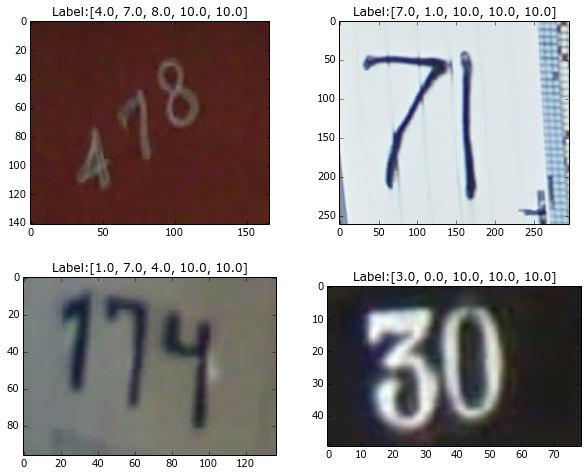

In [7]:
f, axarr = plt.subplots(2, 2, figsize=(10,8))
img_id = 0
for i in range(2):
    for j in range(2): 
        img = misc.imread(train_metadata['file_names'][img_id])
        axarr[i,j].imshow(img, cmap=plt.cm.Greys);
        axarr[i,j].set_title( "Label:" + str(train_metadata['labels'][img_id]))
        img_id += 1

In [28]:
# verify if the data is well balanced across the classes
def display_data_distribution(data):
    data_distribution = np.bincount(data)
    data_range = range(len(data))
    
    index = np.arange(len(data_distribution))
    plt.bar(index, data_distribution)
    plt.xlabel('Classes\n' + str(data_distribution))
    plt.ylabel('Samples')

    bar_width = 0.35
    plt.xticks(index + bar_width, data_range)
    
    plt.show()

Another relevant insight we may ask is what is the distribution of images with different digit sequence lengths? In other words, how many images with a four digit sequence there are? How about two and three?

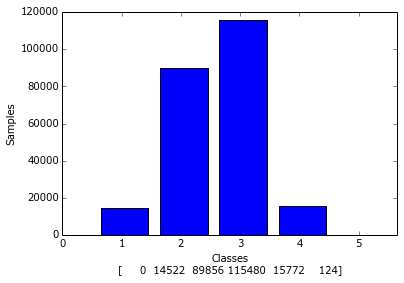

In [29]:
nbboxes = train_metadata['n_bboxes']
display_data_distribution(nbboxes)

We can see that the majority of images have sequences of length 2 and 3 while images with sequence lengths of one four and especially five (with only 124 examples) are somewhat rare. 

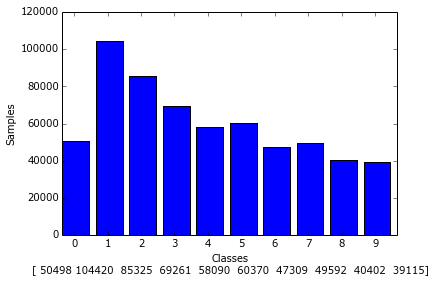

In [30]:
labels = train_metadata['labels']
clean_labels = list(chain.from_iterable(labels))
clean_labels = [x for x in clean_labels if x != 10.0]
display_data_distribution(clean_labels)

In [22]:
def calculate_dataset_distribution_rate(dataset_labels):
    data_distribution = np.bincount(dataset_labels)
    K = len(data_distribution)
    N = len(dataset_labels)
    c = 0
    for ck in data_distribution:
        c += (ck - (N/K))**2

    return (1.0/N)*((1.0/(K-1.0) * c) ** (0.5)) * 100

As we can see, the distribution of images per class is not well balanced. There are much more images of class labels 1 and 2 than any other. Indeed, we notice that there are more than twice as much images from class label '1' than from class label '0', '6', '7', '8', and '9'. In order to have a relative measure of class imbalance, we can define the Degree of Class Imbalance (DCI) as the equation:

\begin{equation*}
DCI = \frac{1}{N} \left( \frac{1}{(K-1)} \sum_{k} \left( |c_k| - \frac{N}{K} \right)^2  \right)^{\frac{1}{2} }
\end{equation*}

This is the standard deviation of  the cluster with respect to "the expected value" of the size of cluster c_k in a balanced problem, divided by N, the number of examples. Using this equation, a DCI closer to 0 means that the problem has a well balanced distribution among the classes. 

In [24]:
print calculate_dataset_distribution_rate(clean_labels)

3.43635920205


As we can see, the DCI * 100 for the (SVHN) training set is not close to zero, which confirms our visual findings that the classes are not well balanced. To better address this issue, we are going to implement some data augmentation algorithms to synthetically increase the dataset size and make this discrepancy less significant.

As for the testing dataset, let's visualize its distribution of sequence’s length and digits.

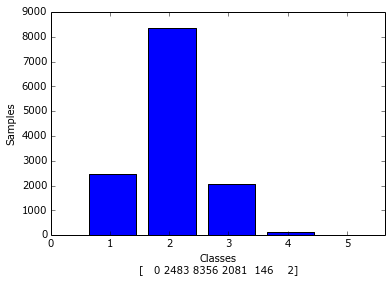

In [31]:
nbboxes = test_metadata['n_bboxes']
display_data_distribution(nbboxes)

We notice that the distribution of sequences' length across the testing dataset differs from the training dataset. While the training dataset distribution resembles a normal distribution, the testing data’s is more skewed to the right. Another interesting point is that there are only 2 images with a sequence length of 5 digits.

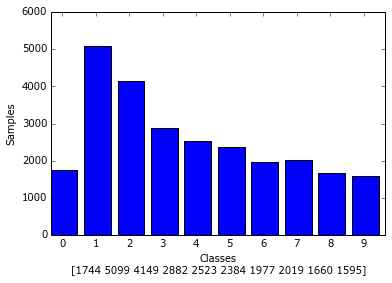

In [32]:
labels = test_metadata['labels']
clean_labels = list(chain.from_iterable(labels))
clean_labels = [x for x in clean_labels if x != 10.0]
display_data_distribution(clean_labels)

Regarding the digits distribution on the testing set, we acknowledge a very similar digit spreading when compared to the training dataset.